### (VRP) Vehicle Routing Problem
- Optimize a set of routes such that
    - all begin and end at the same location(s)
    - serve a set of customers
- Sets:
    - $N=\{1,...,n\}$: set of nodes
- Parameters:
    - $K$: number of vehicles
    - $c_{ij}$: distance (or transportation cost) from node $i$ to node $j$
- Decision variables:
    - $x_j=\begin{cases}1, \quad\text{if the route goes from }i\text{ to }j\\0, \quad\text{O.W.}\end{cases}$
- Notes:
    - $N^{-}=N\backslash\{0\}$, where $N=\{0\}$ is the start and end location
    - $v(S)$: minimum number of vehicles to visit all customers in subset $S$

<br>

$$
\begin{split}
\text{(VRP)}\quad & \text{minimize}\quad \sum\limits_{i,j\in N}c_{ij}x_{ij}\\
&\begin{split}
\text{subject to}\quad\quad \sum\limits_{i\in N}&x_{ih} +\sum\limits_{j\in N}x_{hj}=2 \quad\quad &\forall h\in N^{-}\\
    \sum\limits_{i\in N}&x_{0j}=2K\\
    \sum\limits_{i,j\in S}&x_{ij}\le |S|-v(S) &\forall S\subseteq N^{-}:S\ne \emptyset\\
    &x_{ij}\in \{0,1\}     &\forall i,j\in N^{-}\\ 
    &x_{0j}\in \{0,1,2\}   &\forall j\in N^{-}\\ 
\end{split}
\end{split}
$$

In [1]:
# import libraries
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from gurobipy import Model, GRB, quicksum
%matplotlib inline

In [2]:
# settings
sns.reset_orig
sns.set_style('darkgrid')
sns.set_palette('Set1')

np.set_printoptions(linewidth=200)

In [3]:
# import data
i_data = pd.read_excel('data.xlsx', sheet_name='i_data')
dist_ij = pd.read_excel('data.xlsx', sheet_name='dist_ij').values

In [4]:
# declare the parameters and sets
N = np.arange(len(i_data['X'].values))
K = 5
v = lambda s: 1   # assuming all subroutes require 1 truck

I = [i for i in range(len(N))]
J = I
H = I
A = [(i, j) for i in I for j in J]

S = []
for n in range(1, len(N)):
    S += itertools.combinations(N[1:], int(n))

cost = 2
c = {(i, j): dist_ij[i, j]*2 for (i, j) in A}

In [5]:
# create model
mdl = Model('VRP')

Academic license - for non-commercial use only - expires 2022-08-28
Using license file C:\Users\jack4\gurobi.lic


In [6]:
# add model variables
x = mdl.addVars(A, lb=0.0, ub=2.0, vtype=GRB.INTEGER)

In [7]:
# add objective function
mdl.ModelSense = GRB.MINIMIZE
mdl.setObjective(quicksum(c[i,j]*x[i,j] for i,j in A))

In [8]:
%%time

# add the model constraints
mdl.addConstrs(
    quicksum(x[i,h] for i in I) + 
    quicksum(x[h,j] for j in J) == 2 
    for h in H[1:]
)
mdl.addConstr(quicksum(x[0,j] for j in J[1:]) == 2*K)
mdl.addConstrs(
    quicksum(
        x[i,j] for i,j in itertools.permutations(s, 2)
    ) 
    <= len(s) - v(s)
    for s in S
)
mdl.addConstrs(x[i,j] + x[j,i] <= 1 for i in I[1:] for j in J[1:])
mdl.addConstrs(x[i,j] <= 1 for i in I[1:] for j in J[1:])
mdl.update()

Wall time: 706 ms


In [9]:
%%time

# optimize
mdl.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 16790 rows, 225 columns and 746466 nonzeros
Model fingerprint: 0xa9164242
Variable types: 0 continuous, 225 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+00]
  Objective range  [3e+01, 5e+02]
  Bounds range     [2e+00, 2e+00]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective 4026.3457607
Presolve removed 497 rows and 106 columns
Presolve time: 0.58s
Presolved: 16293 rows, 119 columns, 372869 nonzeros
Variable types: 0 continuous, 119 integer (91 binary)

Root relaxation: objective 1.817769e+03, 15 iterations, 0.13 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0    1817.7694998 1817.76950  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) i

In [10]:
# get the route
routes = [(i,j) for i,j in A if x[i,j].X > 0]
routes

[(0, 1),
 (0, 2),
 (0, 3),
 (0, 4),
 (0, 5),
 (0, 6),
 (0, 12),
 (1, 9),
 (4, 11),
 (7, 5),
 (7, 13),
 (8, 13),
 (9, 8),
 (10, 11),
 (14, 2),
 (14, 10)]

Text(0.5, 1.0, 'Routes')

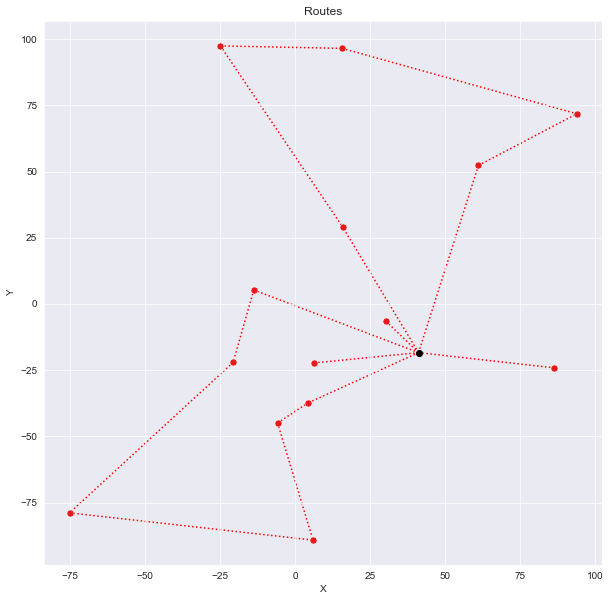

In [11]:
# plot the coverage
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x='X', y='Y', data=i_data, s=50, legend=False, label="Location")
plt.plot(i_data['X'][0], i_data['Y'][0], 'ok')

for path in routes:
    point1 = [i_data['X'][path[0]], i_data['Y'][path[0]]]
    point2 = [i_data['X'][path[1]], i_data['Y'][path[1]]]
    x_values = [point1[0], point2[0]]
    y_values = [point1[1], point2[1]]
    
    plt.plot(x_values, y_values, 'r', linestyle=":", zorder=0)

plt.title('Routes')

In [12]:
# find objective value
print('Objective value =', sum(c[a]*x[a].X for a in A))

Objective value = 1817.7694997733997
